# CNN Example of MNIST Classification



In [1]:
# Reference: https://medium.com/@myringoleMLGOD/simple-convolutional-neural-network-cnn-for-dummies-in-pytorch-a-step-by-step-guide-6f4109f6df80

import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes=10):
        """
        Define the layers of the convolutional neural network.

        Parameters:
            in_channels: int
                The number of channels in the input image. For MNIST, this is 1 (grayscale images).
            num_classes: int
                The number of classes we want to predict, in our case 10 (digits 0 to 9).
        """
        super(CNN, self).__init__()

        # First convolutional layer: 1 input channel, 8 output channels, 3x3 kernel, stride 1, padding 1
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, stride=1, padding=1)
        # Max pooling layer: 2x2 window, stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second convolutional layer: 8 input channels, 16 output channels, 3x3 kernel, stride 1, padding 1
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        # Fully connected layer: 16*7*7 input features (after two 2x2 poolings), 10 output features (num_classes)
        self.fc1 = nn.Linear(16 * 7 * 7, num_classes)

    def forward(self, x):
        """
        Define the forward pass of the neural network.

        Parameters:
            x: torch.Tensor
                The input tensor.

        Returns:
            torch.Tensor
                The output tensor after passing through the network.
        """
        x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = x.reshape(x.shape[0], -1)  # Flatten the tensor
        x = self.fc1(x)            # Apply fully connected layer
        return x



In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

input_size = 784  # 28x28 pixels (not directly used in CNN)
num_classes = 10  # digits 0-9
learning_rate = 0.001
batch_size = 64
num_epochs = 10  # Reduced for demonstration purposes

train_dataset = datasets.MNIST(root="dataset/", download=True, train=True, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root="dataset/", download=True, train=False, transform=transforms.ToTensor())
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

model = CNN(in_channels=1, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
        # Move data and targets to the device (GPU/CPU)
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass: compute the model output
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward pass: compute the gradients
        optimizer.zero_grad()
        loss.backward()

        # Optimization step: update the model parameters
        optimizer.step()

Epoch [1/10]


100%|██████████| 938/938 [00:05<00:00, 163.05it/s]


Epoch [2/10]


100%|██████████| 938/938 [00:05<00:00, 168.12it/s]


Epoch [3/10]


100%|██████████| 938/938 [00:05<00:00, 161.43it/s]


Epoch [4/10]


100%|██████████| 938/938 [00:05<00:00, 163.85it/s]


Epoch [5/10]


100%|██████████| 938/938 [00:05<00:00, 157.16it/s]


Epoch [6/10]


100%|██████████| 938/938 [00:05<00:00, 170.43it/s]


Epoch [7/10]


100%|██████████| 938/938 [00:05<00:00, 174.33it/s]


Epoch [8/10]


100%|██████████| 938/938 [00:05<00:00, 174.74it/s]


Epoch [9/10]


100%|██████████| 938/938 [00:05<00:00, 172.06it/s]


Epoch [10/10]


100%|██████████| 938/938 [00:05<00:00, 174.81it/s]


Checking accuracy on training data
Got 59441/60000 with accuracy 99.07%
Checking accuracy on test data


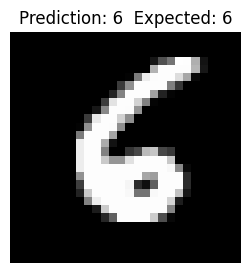

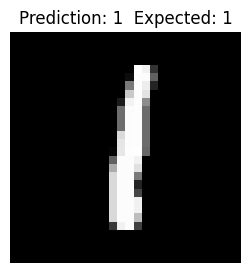

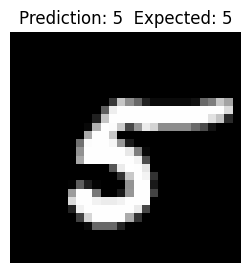

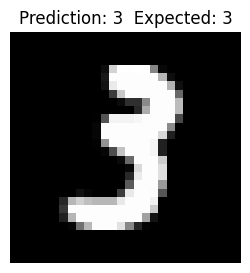

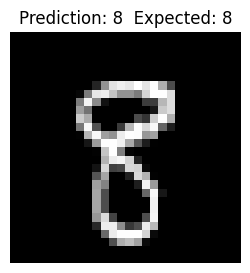

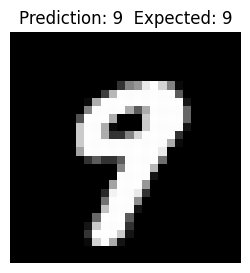

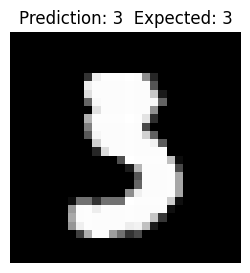

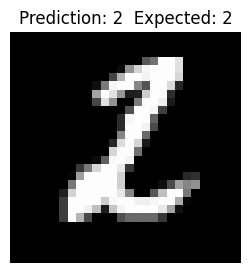

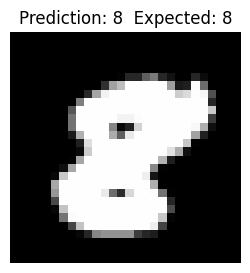

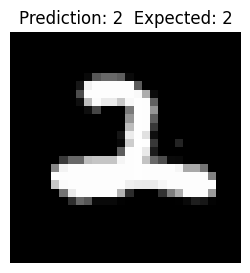

Got 9853/10000 with accuracy 98.53%


In [4]:
def check_accuracy(loader, model, show_every=1000):
    """
    Checks the accuracy of the model on the given dataset loader.
    When using the test loader, shows one example every `show_every` images:
    plots the input and displays predicted vs true label.
    """
    is_train = getattr(loader.dataset, "train", False)
    if is_train:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()  # evaluation mode

    idx = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)

            num_correct += (predictions == y).sum().item()
            num_samples += predictions.size(0)

            # When checking test data, show one example every `show_every` images
            if not is_train:
                for i in range(x.size(0)):
                    if idx % show_every == 0:
                        img = x[i].cpu().squeeze().numpy()
                        plt.figure(figsize=(3, 3))
                        plt.imshow(img, cmap="gray")
                        plt.title(f"Prediction: {predictions[i].item()}  Expected: {y[i].item()}")
                        plt.axis("off")
                        plt.show()
                    idx += 1

    accuracy = float(num_correct) / float(num_samples) * 100
    print(f"Got {num_correct}/{num_samples} with accuracy {accuracy:.2f}%")

    model.train()

# Final accuracy check on training and test sets
check_accuracy(train_loader, model)
check_accuracy(test_loader, model)